
Training with epsilon-greedy policy, epsilon = 0.1...
Converged after 1795 episodes with epsilon-greedy policy.


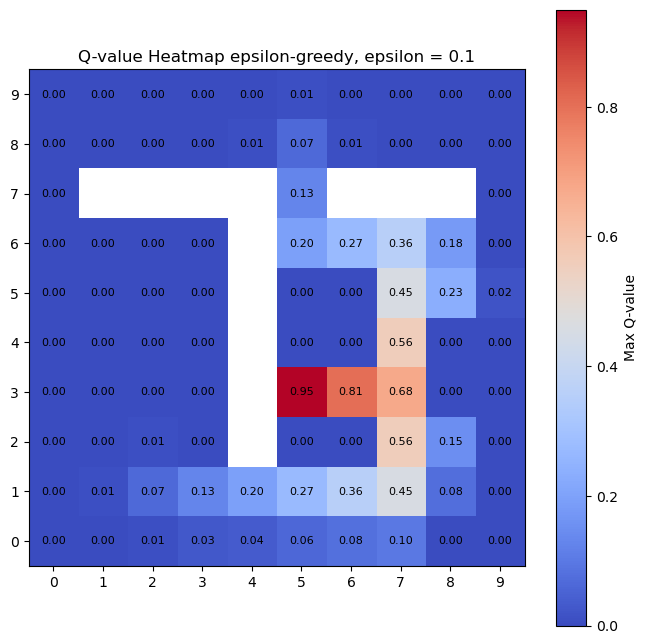


Training with epsilon-greedy policy, epsilon = 0.2...
Converged after 1922 episodes with epsilon-greedy policy.


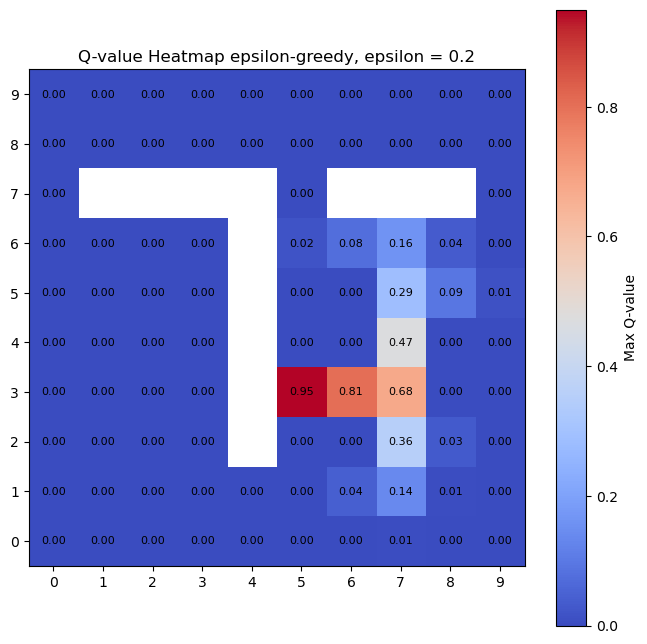


Training with epsilon-greedy policy, epsilon = 0.3...
Converged after 1719 episodes with epsilon-greedy policy.


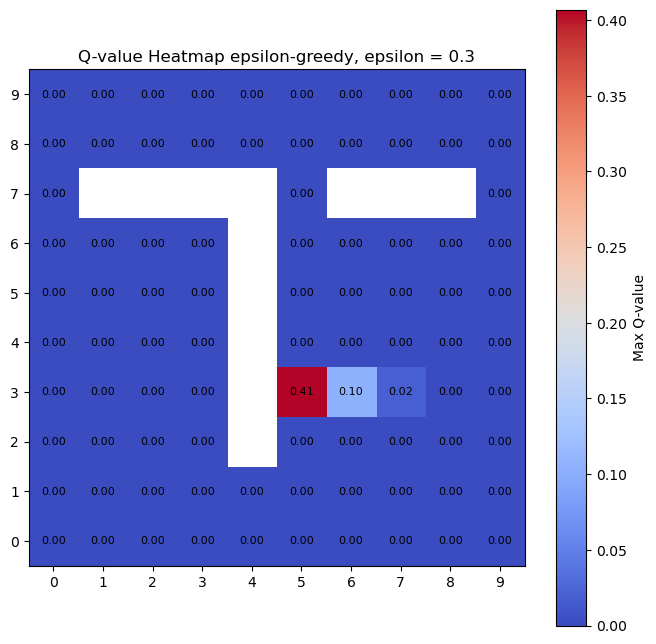


Training with boltzmann policy...
Converged after 1490 episodes with boltzmann policy.


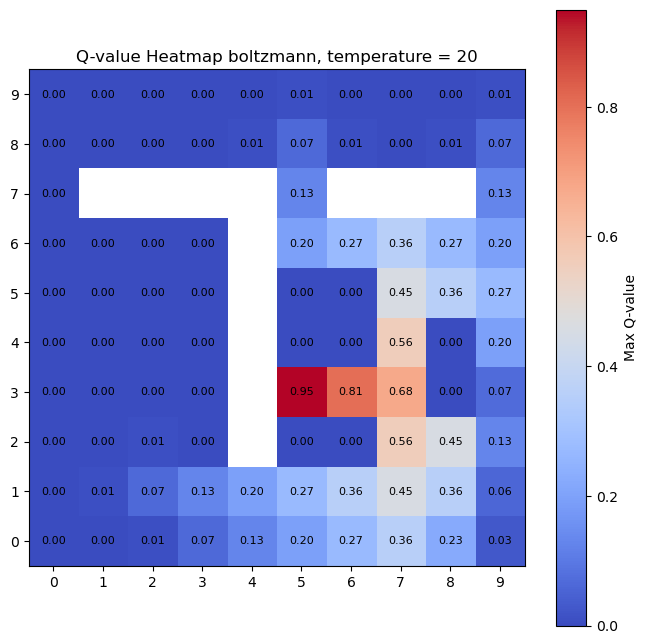

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Define the environment
board_rows = 10
board_cols = 10
board = np.zeros((board_rows, board_cols))
win_state = [(4, 5)]
loss_state = [(6, 3), (2, 3), (2, 5), (2, 6), (5, 5), (5, 6), (4, 6), (3, 8), (4, 8)]
gray_state = [
    (7, 1), (7, 2), (7, 3), (7, 4),
    (6, 4), (5, 4), (4, 4), (3, 4), (2, 4),
    (7, 6), (7, 7), (7, 8)
]
start = (9, 0) 
deterministic = True

class State:
    def __init__(self, start, board, win_state, loss_state, gray_state):
        self.board = board
        self.win_state = win_state
        self.loss_state = loss_state
        self.gray_state = gray_state
        self.start = start
        self.state = start
        self.isEnd = False
        self.deterministic = deterministic

    def giveReward(self):
        if self.state in self.win_state:
            return 1
        elif self.state in self.loss_state:
            return -1
        else:
            return 0

    def isEndFunc(self):
        if (self.state in self.win_state) or (self.state in self.loss_state):
            self.isEnd = True

    def nextPosition(self, action):
        if self.deterministic:
            if action == "up":
                next_state = (self.state[0] + 1, self.state[1])  
            elif action == "down":
                next_state = (self.state[0] - 1, self.state[1])  
            elif action == "left":
                next_state = (self.state[0], self.state[1] - 1)
            elif action == "right":
                next_state = (self.state[0], self.state[1] + 1)

            if (0 <= next_state[0] < board_rows) and (0 <= next_state[1] < board_cols):
                if next_state not in self.gray_state:
                    return next_state
            return self.state

class Agent:
    def __init__(self, exp_rate=0.3, temperature=1.0, temperature_decay=0.99):
        self.actions = ["up", "down", "left", "right"]
        self.State = State(start, board, win_state, loss_state, gray_state)
        self.learning_rate = 0.01
        self.discount = 0.9

        # Exploration settings
        self.exp_rate = exp_rate  # For epsilon-greedy
        self.temperature = temperature  # For Boltzmann exploration
        self.temperature_decay = temperature_decay

        # Initialize Q-values
        self.Q_values = {}
        for i in range(board_rows):
            for j in range(board_cols):
                self.Q_values[(i, j)] = {a: 0 for a in self.actions}

    def softmax(self, q_values, temperature):
        max_q = max(q_values.values())
        exp_q = {a: math.exp((q - max_q) / temperature) for a, q in q_values.items()}
        total = sum(exp_q.values())
        return {a: exp_q[a] / total for a in q_values.keys()}

    def chooseAction(self, exploration_policy="epsilon-greedy"):
        if exploration_policy == "epsilon-greedy":
            if np.random.uniform(0, 1) <= self.exp_rate:
                return np.random.choice(self.actions)
            else:
                current_state = self.State.state
                q_values = self.Q_values[current_state]
                max_q = max(q_values.values())
                max_actions = [a for a, q in q_values.items() if q == max_q]
                return np.random.choice(max_actions)
        elif exploration_policy == "boltzmann":
            current_state = self.State.state
            q_values = self.Q_values[current_state]
            probabilities = self.softmax(q_values, self.temperature)
            actions, probs = zip(*probabilities.items())
            return np.random.choice(actions, p=probs)

    def TakeAction(self, action):
        position = self.State.nextPosition(action)
        return State(position, board, win_state, loss_state, gray_state)

    def reset(self):
        self.State = State(start, board, win_state, loss_state, gray_state)

    def play(self, rounds=10000, exploration_policy="epsilon-greedy", max_steps_per_episode=10000):
        convergence_threshold = 1e-3
        for episode in range(rounds):
            self.reset()
            max_change = 0
            steps = 0
            while not self.State.isEnd and steps < max_steps_per_episode:
                current_state = self.State.state
                action = self.chooseAction(exploration_policy)
                self.State = self.TakeAction(action)
                reward = self.State.giveReward()
                next_state = self.State.state
                self.State.isEndFunc()

                # Q-learning update
                q_current = self.Q_values[current_state][action]
                if self.State.isEnd:
                    q_target = reward
                else:
                    q_target = reward + self.discount * max(self.Q_values[next_state].values())
                updated_q_value = q_current + self.learning_rate * (q_target - q_current)
                max_change = max(max_change, abs(updated_q_value - q_current))
                self.Q_values[current_state][action] = round(updated_q_value, 3)

                # Reset if end state is reached
                if self.State.isEnd and self.State.state in self.State.win_state:
                    self.State = State(start, board, win_state, loss_state, gray_state)
                elif self.State.isEnd:
                    break  # Episode ends on losing state

                steps += 1

                # Decay exploration parameters if needed
                if exploration_policy == "boltzmann":
                    self.temperature = max(0.1, self.temperature * self.temperature_decay)


            if max_change < convergence_threshold:
                print(f"Converged after {episode + 1} episodes with {exploration_policy} policy.")
                break

    def visualize_q_values(self, q_values, gray_state, board_rows=10, board_cols=10):
        grid = np.zeros((board_rows, board_cols))
        for i in range(board_rows):
            for j in range(board_cols):
                if (i, j) in gray_state:
                    grid[i, j] = np.nan
                else:
                    grid[i, j] = max(q_values[(i, j)].values())
        plt.figure(figsize=(8, 8))
        plt.imshow(grid, cmap="coolwarm", interpolation="nearest")
        plt.colorbar(label="Max Q-value")
        if policy == "epsilon-greedy":
            plt.title(f"Q-value Heatmap {policy}, epsilon = {self.exp_rate}")
        elif policy == "boltzmann":
            plt.title(f"Q-value Heatmap {policy}, temperature = 20")
        plt.xticks(range(board_cols))
        plt.yticks(range(board_rows))
        plt.gca().invert_yaxis()
        for i in range(board_rows):
            for j in range(board_cols):
                if not np.isnan(grid[i, j]):
                    plt.text(j, i, f"{grid[i, j]:.2f}", ha="center", va="center", fontsize=8, color="black")
        if policy == 'epsilon-greedy':
            plt.savefig(f"q_values_{policy}_{self.exp_rate}.jpeg", dpi = 600)
        elif policy == 'boltzmann':
            plt.savefig(f"q_values_{policy}_T20.jpeg", dpi = 600)
        plt.show()

    def display_converged_q_values(self, q_values):
        for state, actions in q_values.items():
            print(f"State {state}: {actions}")

if __name__ == "__main__":
    policies = ["epsilon-greedy", "boltzmann"]
    for policy in policies:
        if policy == "epsilon-greedy":
            for exp_rate in [0.1, 0.2, 0.3]:
                print(f"\nTraining with {policy} policy, epsilon = {exp_rate}...")
                ag = Agent(exp_rate=exp_rate)
                ag.play(10000, exploration_policy=policy)
                ag.visualize_q_values(ag.Q_values, gray_state)
                # ag.display_converged_q_values(ag.Q_values)
        elif policy == "boltzmann":
            print(f"\nTraining with {policy} policy...")
            ag = Agent(temperature=20.0, temperature_decay=0.99)
            ag.play(10000, exploration_policy=policy)
            ag.visualize_q_values(ag.Q_values, gray_state)
            # ag.display_converged_q_values(ag.Q_values)